In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.semi_supervised import LabelSpreading
from imblearn.over_sampling import SMOTE

rng = np.random.RandomState(0)
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

In [12]:
h = .02
y_30 = np.copy(y)
y_30[rng.rand(len(y)) < 0.3] = -1
y_50 = np.copy(y)
y_50[rng.rand(len(y)) < 0.5] = -1

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
ls30  = (LabelSpreading().fit(X, y_30), y_30)
ls50  = (LabelSpreading().fit(X, y_50), y_50)
ls100 = (LabelSpreading().fit(X, y), y)

In [13]:
rbf_svc = (svm.SVC(kernel = 'rbf', gamma = 0.5).fit(X, y), y)

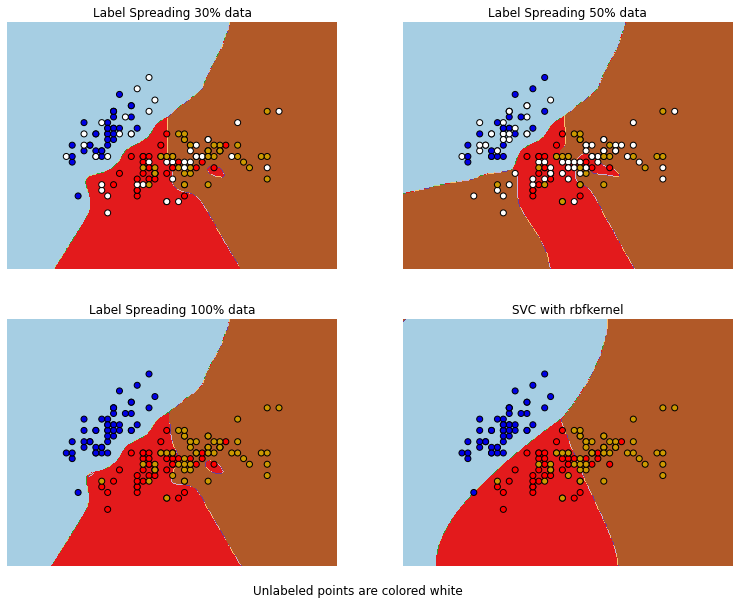

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score

x_min, x_max = X[:, 0].min() -1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() -1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
titles = ['Label Spreading 30% data', 'Label Spreading 50% data', 'Label Spreading 100% data', 'SVC with rbfkernel']
color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.8, .6, 0)}


plt.figure(figsize = (13, 10))
for i, (clf, y_train) in enumerate((ls30, ls50, ls100, rbf_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].

    plt.subplot(2, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired)
    plt.axis('off')
    
    # Plot also the training points
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c = colors, edgecolors = 'black')
    plt.title(titles[i])

plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()

In [31]:
from sklearn.datasets import make_classification
from collections import Counter

X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant = 0, 
                           n_clusters_per_class = 1, weights=[0.99], 
                           flip_y = 0, random_state = 1)

counter = Counter(y)
counter

Counter({0: 9900, 1: 100})

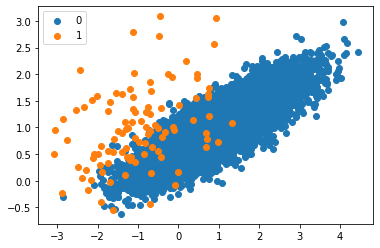

In [32]:
from numpy import where

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()


Counter({0: 9900, 1: 9900})


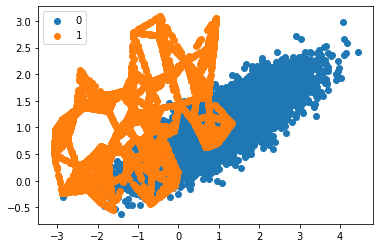

In [34]:
oversample = SMOTE()

X, y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [35]:
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)